In [157]:
# Importing necessary libraries

import pandas as pd
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [158]:
# Reading dataframe from csv file
df_train = pd.read_csv("data_DS_HW_train.csv", delimiter=';')
df_train

,application_id,loan_date_created,activeloan_coalt,applicationamount,applicationprice,avgbetweenapplications,avgbetweenapprovedapplications,avgextensions,avgloanterm,countapplicationsafterlastloanclose,...,informationcount,debtorscount,creditorscount,amount,providerscount,paidobligationscount,averagepaiddebt,averagepaymenttimeindays,sumpaiddebt,TARGET
0,4275,29.11.2020,0,2500,"402,11",0,0,0,0,1,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,1
1,9635,17.02.2021,0,600,0,0,0,0,30,1,...,0.0,0.0,0.0,0,1.0,2.0,1500,1.0,3000,0
2,5383,14.12.2020,0,500,0,0,0,0,0,1,...,0.0,0.0,0.0,0,2.0,3.0,"466,67",0.0,1400,0
3,442,05.10.2020,0,500,0,"0,01",0,0,0,2,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0
4,5070,10.12.2020,0,300,0,0,0,0,0,1,...,0.0,0.0,0.0,0,2.0,18.0,"459,15",0.0,"8264,71",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4831,07.12.2020,0,1500,"120,63",0,0,0,0,1,...,0.0,0.0,0.0,0,2.0,12.0,"3432,28",0.0,"41187,39",0
9996,4013,25.11.2020,0,1000,"80,42",0,0,0,0,1,...,0.0,0.0,0.0,0,1.0,8.0,"672,53",1.0,"5380,26",0
9997,10391,01.03.2021,0,500,0,0,0,0,30,1,...,0.0,0.0,0.0,0,1.0,3.0,"688,86",3.0,"2066,58",0
9998,17222,11.01.2021,0,600,0,0,0,0,30,1,...,0.0,0.0,0.0,0,2.0,5.0,"1940,06",0.0,"9700,3",0


In [159]:

# Taking all columns which are 'object' dtype and if contains ',' to convert it later into a float
numeric_columns_with_commas = [
    col for col in df_train.columns 
    if df_train[col].dtype == 'object' and df_train[col].str.contains(',').any()
]


# Converting those columns to floats and replace commas to a dots
for col in numeric_columns_with_commas:
    df_train[col] = pd.to_numeric(df_train[col].str.replace(',', '.'), errors='coerce')

# Check the data types again to see if the conversion was successful
df_train.dtypes


application_id                int64
loan_date_created            object
activeloan_coalt              int64
applicationamount             int64
applicationprice            float64
                             ...   
paidobligationscount        float64
averagepaiddebt             float64
averagepaymenttimeindays    float64
sumpaiddebt                 float64
TARGET                        int64
Length: 235, dtype: object

In [160]:
# Managing datetime column

df_train['loan_date_created'] = pd.to_datetime(df_train['loan_date_created'], format='%d.%m.%Y')

# Extracting featues from this datetime column and create new columns 
df_train['year'] = df_train['loan_date_created'].dt.year
df_train['month'] = df_train['loan_date_created'].dt.month
df_train['day'] = df_train['loan_date_created'].dt.day
df_train['dayofweek'] = df_train['loan_date_created'].dt.dayofweek
df_train['hour'] = df_train['loan_date_created'].dt.hour

# Deleting this datetime column after extracting important features
df_train = df_train.drop(['loan_date_created'], axis = 1)

df_train

,application_id,activeloan_coalt,applicationamount,applicationprice,avgbetweenapplications,avgbetweenapprovedapplications,avgextensions,avgloanterm,countapplicationsafterlastloanclose,countrejectedapplications,...,paidobligationscount,averagepaiddebt,averagepaymenttimeindays,sumpaiddebt,TARGET,year,month,day,dayofweek,hour
0,4275,0,2500,402.11,0.00,0.0,0.0,0.0,1,0,...,0.0,0.00,0.0,0.00,1,2020,11,29,6,0
1,9635,0,600,0.00,0.00,0.0,0.0,30.0,1,0,...,2.0,1500.00,1.0,3000.00,0,2021,2,17,2,0
2,5383,0,500,0.00,0.00,0.0,0.0,0.0,1,0,...,3.0,466.67,0.0,1400.00,0,2020,12,14,0,0
3,442,0,500,0.00,0.01,0.0,0.0,0.0,2,0,...,0.0,0.00,0.0,0.00,0,2020,10,5,0,0
4,5070,0,300,0.00,0.00,0.0,0.0,0.0,1,0,...,18.0,459.15,0.0,8264.71,0,2020,12,10,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4831,0,1500,120.63,0.00,0.0,0.0,0.0,1,0,...,12.0,3432.28,0.0,41187.39,0,2020,12,7,0,0
9996,4013,0,1000,80.42,0.00,0.0,0.0,0.0,1,0,...,8.0,672.53,1.0,5380.26,0,2020,11,25,2,0
9997,10391,0,500,0.00,0.00,0.0,0.0,30.0,1,0,...,3.0,688.86,3.0,2066.58,0,2021,3,1,0,0
9998,17222,0,600,0.00,0.00,0.0,0.0,30.0,1,1,...,5.0,1940.06,0.0,9700.30,0,2021,1,11,0,0


In [161]:
# Checking the missing values in columns
missing_values = df_train.isnull().sum()

# sorting the missing values in decreasing orded
missing_values = missing_values.sort_values(ascending=False)

missing_values

policyrule_partialdecision                      9546
swo_ind_overdue_loans_number                    9414
swo_ind_same_ip_different_pesel_count_unique    9024
swo_ind_same_ip_different_pesel_count           9024
days_after_knownsince_pbd                       6715
                                                ... 
swo_ind_loans_amount_p0_90                         0
swo_ind_loans_amount_p0_210                        0
swo_ind_loans_amount_p0_360                        0
swo_ind_loans_amount_p0_plus                       0
hour                                               0
Length: 239, dtype: int64

In [162]:
# Calculating the percentage of missing data for each column
missing_percentage = df_train.isnull().mean() * 100

# When there is more than 50% missing data we drop the column
columns_to_drop = missing_percentage[missing_percentage > 50].index
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_train

,application_id,activeloan_coalt,applicationamount,applicationprice,avgbetweenapplications,avgbetweenapprovedapplications,avgextensions,avgloanterm,countapplicationsafterlastloanclose,countrejectedapplications,...,paidobligationscount,averagepaiddebt,averagepaymenttimeindays,sumpaiddebt,TARGET,year,month,day,dayofweek,hour
0,4275,0,2500,402.11,0.00,0.0,0.0,0.0,1,0,...,0.0,0.00,0.0,0.00,1,2020,11,29,6,0
1,9635,0,600,0.00,0.00,0.0,0.0,30.0,1,0,...,2.0,1500.00,1.0,3000.00,0,2021,2,17,2,0
2,5383,0,500,0.00,0.00,0.0,0.0,0.0,1,0,...,3.0,466.67,0.0,1400.00,0,2020,12,14,0,0
3,442,0,500,0.00,0.01,0.0,0.0,0.0,2,0,...,0.0,0.00,0.0,0.00,0,2020,10,5,0,0
4,5070,0,300,0.00,0.00,0.0,0.0,0.0,1,0,...,18.0,459.15,0.0,8264.71,0,2020,12,10,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4831,0,1500,120.63,0.00,0.0,0.0,0.0,1,0,...,12.0,3432.28,0.0,41187.39,0,2020,12,7,0,0
9996,4013,0,1000,80.42,0.00,0.0,0.0,0.0,1,0,...,8.0,672.53,1.0,5380.26,0,2020,11,25,2,0
9997,10391,0,500,0.00,0.00,0.0,0.0,30.0,1,0,...,3.0,688.86,3.0,2066.58,0,2021,3,1,0,0
9998,17222,0,600,0.00,0.00,0.0,0.0,30.0,1,1,...,5.0,1940.06,0.0,9700.30,0,2021,1,11,0,0


In [163]:
# Filling missing data in columns which are floats or integers with median 

for column in df_train.columns:
    # Checking if the column data type is integer or float
    if df_train[column].dtype == 'float64' or df_train[column].dtype == 'int64':
        # Calculating the median of this column
        median_value = df_train[column].median()
        # Fillin missing values in this column with median
        df_train[column].fillna(median_value, inplace=True)
        
df_train

,application_id,activeloan_coalt,applicationamount,applicationprice,avgbetweenapplications,avgbetweenapprovedapplications,avgextensions,avgloanterm,countapplicationsafterlastloanclose,countrejectedapplications,...,paidobligationscount,averagepaiddebt,averagepaymenttimeindays,sumpaiddebt,TARGET,year,month,day,dayofweek,hour
0,4275,0,2500,402.11,0.00,0.0,0.0,0.0,1,0,...,0.0,0.00,0.0,0.00,1,2020,11,29,6,0
1,9635,0,600,0.00,0.00,0.0,0.0,30.0,1,0,...,2.0,1500.00,1.0,3000.00,0,2021,2,17,2,0
2,5383,0,500,0.00,0.00,0.0,0.0,0.0,1,0,...,3.0,466.67,0.0,1400.00,0,2020,12,14,0,0
3,442,0,500,0.00,0.01,0.0,0.0,0.0,2,0,...,0.0,0.00,0.0,0.00,0,2020,10,5,0,0
4,5070,0,300,0.00,0.00,0.0,0.0,0.0,1,0,...,18.0,459.15,0.0,8264.71,0,2020,12,10,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4831,0,1500,120.63,0.00,0.0,0.0,0.0,1,0,...,12.0,3432.28,0.0,41187.39,0,2020,12,7,0,0
9996,4013,0,1000,80.42,0.00,0.0,0.0,0.0,1,0,...,8.0,672.53,1.0,5380.26,0,2020,11,25,2,0
9997,10391,0,500,0.00,0.00,0.0,0.0,30.0,1,0,...,3.0,688.86,3.0,2066.58,0,2021,3,1,0,0
9998,17222,0,600,0.00,0.00,0.0,0.0,30.0,1,1,...,5.0,1940.06,0.0,9700.30,0,2021,1,11,0,0


In [164]:
# Ensuring the 'TARGET' column has no missing values and if yes, then we delete those rows
if df_train['TARGET'].isnull().any():
    df_train_dropped = df_train_dropped.dropna(subset=['TARGET'])
    
df_train

,application_id,activeloan_coalt,applicationamount,applicationprice,avgbetweenapplications,avgbetweenapprovedapplications,avgextensions,avgloanterm,countapplicationsafterlastloanclose,countrejectedapplications,...,paidobligationscount,averagepaiddebt,averagepaymenttimeindays,sumpaiddebt,TARGET,year,month,day,dayofweek,hour
0,4275,0,2500,402.11,0.00,0.0,0.0,0.0,1,0,...,0.0,0.00,0.0,0.00,1,2020,11,29,6,0
1,9635,0,600,0.00,0.00,0.0,0.0,30.0,1,0,...,2.0,1500.00,1.0,3000.00,0,2021,2,17,2,0
2,5383,0,500,0.00,0.00,0.0,0.0,0.0,1,0,...,3.0,466.67,0.0,1400.00,0,2020,12,14,0,0
3,442,0,500,0.00,0.01,0.0,0.0,0.0,2,0,...,0.0,0.00,0.0,0.00,0,2020,10,5,0,0
4,5070,0,300,0.00,0.00,0.0,0.0,0.0,1,0,...,18.0,459.15,0.0,8264.71,0,2020,12,10,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4831,0,1500,120.63,0.00,0.0,0.0,0.0,1,0,...,12.0,3432.28,0.0,41187.39,0,2020,12,7,0,0
9996,4013,0,1000,80.42,0.00,0.0,0.0,0.0,1,0,...,8.0,672.53,1.0,5380.26,0,2020,11,25,2,0
9997,10391,0,500,0.00,0.00,0.0,0.0,30.0,1,0,...,3.0,688.86,3.0,2066.58,0,2021,3,1,0,0
9998,17222,0,600,0.00,0.00,0.0,0.0,30.0,1,1,...,5.0,1940.06,0.0,9700.30,0,2021,1,11,0,0


In [165]:
# Creating label encoder from sklearn library
label_encoder = preprocessing.LabelEncoder()

for column in df_train.columns:
    # Checking if the column data type is not float and integer to label encode only strings
    if df_train[column].dtype != 'float64' and df_train[column].dtype != 'int64':
        # Creating labels in columns which are not float and integers using label encoder
        df_train[column]= label_encoder.fit_transform(df_train[column])
        
        
        

In [166]:
for column in df_train.columns:
    # Checking if there are columns which are not floats or integer
    if df_train[column].dtype != 'float64' and df_train[column].dtype != 'int64':
        print(df_train[column])

In [167]:
# Cleaning test dataset using the same procedures as in testing dataset

df_test = pd.read_csv("data_DS_HW_test.csv", delimiter=';')

# Taking all columns which are 'object' dtype and if contains ',' to convert it later into a float
numeric_columns_with_commas = [
    col for col in df_test.columns 
    if df_test[col].dtype == 'object' and df_test[col].str.contains(',').any()
]


# Converting those columns to floats and replace commas to a dots
for col in numeric_columns_with_commas:
    df_test[col] = pd.to_numeric(df_test[col].str.replace(',', '.'), errors='coerce')
    

# Managing datetime column

df_test['loan_date_created'] = pd.to_datetime(df_test['loan_date_created'],  format='%d.%m.%Y')

# Extracting featues from this datetime column and create new columns 
df_test['year'] = df_test['loan_date_created'].dt.year
df_test['month'] = df_test['loan_date_created'].dt.month
df_test['day'] = df_test['loan_date_created'].dt.day
df_test['dayofweek'] = df_test['loan_date_created'].dt.dayofweek
df_test['hour'] = df_test['loan_date_created'].dt.hour

# Deleting this datetime column after extracting important features
df_test = df_test.drop(['loan_date_created'], axis = 1)

df_test

# Check the data types again to see if the conversion was successful
df_test.dtypes



# Calculating the percentage of missing data for each column
missing_percentage = df_test.isnull().mean() * 100

# When there is more than 50% missing data we drop the column
columns_to_drop = missing_percentage[missing_percentage > 50].index
df_test.drop(columns_to_drop, axis=1, inplace=True)


# Filling missing data in columns which are floats or integers with median 

for column in df_test.columns:
    # Checking if the column data type is integer or float
    if df_test[column].dtype == 'float64' or df_test[column].dtype == 'int64':
        # Calculating the median of this column
        median_value = df_test[column].median()
        # Fillin missing values in this column with median
        df_test[column].fillna(median_value, inplace=True)
        


    
    
    
# Creating label encoder from sklearn library
label_encoder = preprocessing.LabelEncoder()

for column in df_test.columns:
    # Checking if the column data type is not float and integer to label encode only strings
    if df_test[column].dtype != 'float64' and df_test[column].dtype != 'int64':
        # Creating labels in columns which are not float and integers using label encoder
        df_test[column]= label_encoder.fit_transform(df_test[column])
        
for column in df_test.columns:
    # Checking if there are columns which are not floats or integer
    if df_test[column].dtype != 'float64' and df_test[column].dtype != 'int64':
        print(df_test[column])    
        
        
df_test



/tmp/ipykernel_43576/1362925788.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv("data_DS_HW_test.csv", delimiter=';')


,application_id,activeloan_coalt,applicationamount,applicationprice,avgbetweenapplications,avgbetweenapprovedapplications,avgextensions,avgloanterm,countapplicationsafterlastloanclose,countrejectedapplications,...,providerscount,paidobligationscount,averagepaiddebt,averagepaymenttimeindays,sumpaiddebt,year,month,day,dayofweek,hour
0,223,1,1000,0.00,0.0,0.00,0.0,30.0,1,1,...,2.0,6.0,2857.36,0.0,17144.15,0,3,1,4,0
1,20671,0,600,0.00,0.0,0.00,0.0,0.0,1,0,...,1.0,4.0,1842.98,6.0,7371.91,1,2,2,2,0
2,2218,0,200,0.00,0.0,0.00,0.0,0.0,1,1,...,2.0,12.0,1284.60,0.0,15415.21,0,4,3,2,0
3,19196,0,3000,361.91,0.0,0.00,0.0,0.0,1,0,...,2.0,10.0,1286.99,2.0,12869.88,1,1,7,0,0
4,13088,0,2500,402.11,0.0,0.00,0.0,0.0,1,0,...,2.0,5.0,535.80,9.0,2679.02,0,3,26,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4641,7471,0,3000,482.54,0.0,30.01,0.0,27.5,1,0,...,2.0,2.0,2750.00,0.0,5500.00,1,0,14,4,0
4642,5134,0,1000,160.85,0.0,0.00,0.0,0.0,1,4,...,1.0,1.0,1936.40,13.0,1936.40,0,5,10,4,0
4643,10510,0,500,0.00,0.0,0.00,0.0,0.0,1,1,...,1.0,7.0,1084.97,0.0,7594.79,1,2,2,2,0
4644,12137,0,1000,0.00,0.0,0.00,0.0,0.0,1,2,...,1.0,2.0,1732.35,0.0,3464.70,0,3,14,3,0


In [168]:
X = df_train.drop('TARGET', axis=1)  # Features
y = df_train['TARGET']  # Labels

In [169]:
# Reducing dimensionality using PCA components
X_std = StandardScaler().fit_transform(X)

# Instantiate PCA object
pca = PCA(n_components=2) # Reduce data to 2 dimensions

# Fit and transform the data
X = pca.fit_transform(X_std)

In [170]:
# Spliting data on train and test sets to evaluate performance of the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

X_train

array([[-3.69197785, -1.75098319],
       [ 1.50899592, -1.89843933],
       [-0.48241608, -3.08900775],
       ...,
       [-5.15397159, -1.62832994],
       [-5.21474053, -2.52033163],
       [-3.57057774, -2.08508333]])

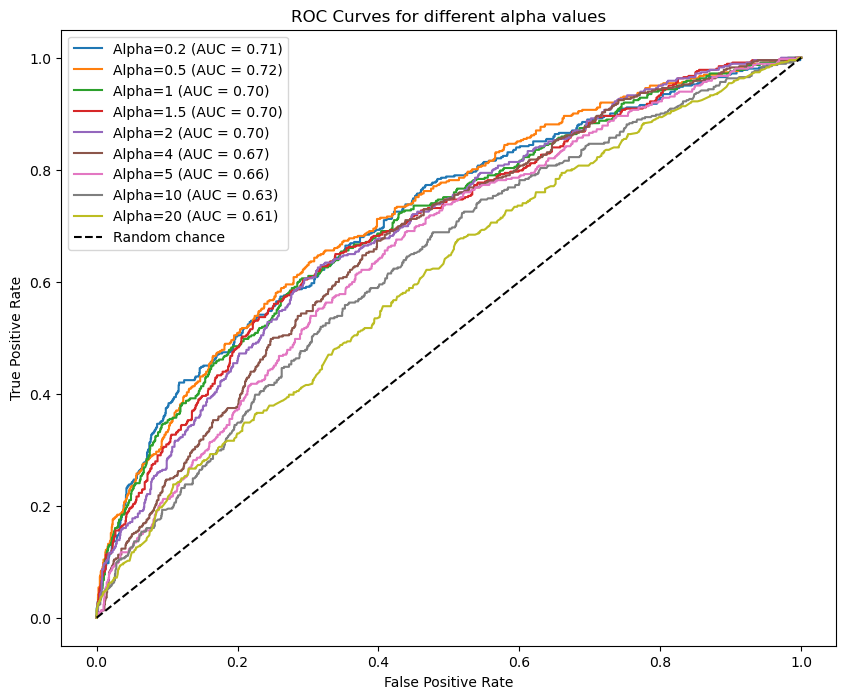

In [177]:
# Selected learning rate values which will be tested to check the model performance
alpha_values = [0.2, 0.5, 1, 1.5, 2, 4, 5, 10, 20]

# There will be stored performance of a model
model_performance = {}

for alpha in alpha_values:
    # Applying XGBoost model with some alpha value, applying random_state to see the same performance later
    model = XGBClassifier(eval_metric = 'logloss', reg_alpha = alpha, random_state = 50)
    
    # Fitting the model to training data
    model.fit(X_train, y_train)
    
    # Predicting probabilities on test data
    y_pred_proba = model.predict_proba(X_test)[:,1]
    

    # Calculating AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Calculating ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Storing results to models_performance, to compare different learning rate values to choose the best model
    model_performance[alpha] = {"AUC": auc_score, "FPR": fpr, "TPR": tpr}
    
    
# PLOTTING ROC CURVE
plt.figure(figsize=(10, 8))
for alpha, performance in model_performance.items():
    plt.plot(performance['FPR'], performance['TPR'], label=f'Alpha={alpha} (AUC = {performance["AUC"]:.2f})')
    
# ploting random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title('ROC Curves for different alpha values')
plt.legend(loc='upper left')
plt.show()


In [172]:
# We choose alpha = 0.2 because the model which this learning rate had the best performance
# Applying XGBoost model with alpha value = 0.2
model = XGBClassifier(eval_metric = 'logloss', reg_alpha = 0.2, random_state = 50)

# Fitting the model to training data - learning model on training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=50, ...)

In [173]:
# Applying this model predictions to a test dataset

# scaling test dataset using the same dimension reduction as in train dataset
X_test = df_test
X_test_std = StandardScaler().fit_transform(X_test)


X_test_pca = pca.transform(X_test_std)


predictions = model.predict(X_test_pca)



In [174]:
# Applying target column to a test dataframe using model predictions
df_test['TARGET'] = predictions

In [175]:
# Saving new dataset to a csv file
df_test.to_csv("df_test.csv")